# Evaluator Notebook

This notebook demonstrates how to evaluate and analyze the effects of reasoning direction interventions on model outputs.

In [1]:
import sys
sys.path.append('../pipeline')

import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from evaluator import ReasoningEvaluator
from transformers import AutoTokenizer

import os
# Set HuggingFace cache directory to scratch to avoid home directory out of memory
os.environ['HF_HOME'] = '/scratch/gilbreth/sramishe'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/gilbreth/sramishe/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/gilbreth/sramishe/datasets'


print(f"HuggingFace cache directory set to: {os.environ['HF_HOME']}")

/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFace cache directory set to: /scratch/gilbreth/sramishe


## Initialize Evaluator

In [2]:
evaluator = ReasoningEvaluator()
tokenizer = AutoTokenizer.from_pretrained("Qwen/QwQ-32B-Preview")

## Test Text Examples

In [3]:
# Example outputs with <think> tags
baseline_text = """
User: What is 2+2?
Assistant: <think>
Let me calculate this.
2 + 2 = 4
</think>
The answer is 4.
"""

intervened_text = """
User: What is 2+2?
Assistant: <think>
Let me think about this carefully.
We're adding two numbers: 2 and 2.
Wait, let me make sure I understand the question.
2 plus 2...
Maybe I should reconsider the approach.
Actually, 2 + 2 = 4.
Yes, that's correct.
</think>
The answer is 4.
"""

## Extract and Analyze Think Tags

In [4]:
# Extract think content
baseline_think, baseline_non_think = evaluator.extract_think_tags(baseline_text)
intervened_think, intervened_non_think = evaluator.extract_think_tags(intervened_text)

print("BASELINE - Think content:")
print(baseline_think)
print("\nBASELINE - Non-think content:")
print(baseline_non_think)
print("\n" + "="*60 + "\n")
print("INTERVENED - Think content:")
print(intervened_think)
print("\nINTERVENED - Non-think content:")
print(intervened_non_think)

BASELINE - Think content:

Let me calculate this.
2 + 2 = 4


BASELINE - Non-think content:

User: What is 2+2?
Assistant: 
The answer is 4.



INTERVENED - Think content:

Let me think about this carefully.
We're adding two numbers: 2 and 2.
Wait, let me make sure I understand the question.
2 plus 2...
Maybe I should reconsider the approach.
Actually, 2 + 2 = 4.
Yes, that's correct.


INTERVENED - Non-think content:

User: What is 2+2?
Assistant: 
The answer is 4.



## Count Tokens

In [5]:
baseline_counts = evaluator.count_tokens(baseline_text, tokenizer, split_by_tags=True)
intervened_counts = evaluator.count_tokens(intervened_text, tokenizer, split_by_tags=True)

print("Token Counts:")
print("\nBaseline:")
for key, value in baseline_counts.items():
    print(f"  {key}: {value}")

print("\nIntervened:")
for key, value in intervened_counts.items():
    print(f"  {key}: {value}")

Token Counts:

Baseline:
  think_tokens: 14
  non_think_tokens: 19
  total_tokens: 37

Intervened:
  think_tokens: 60
  non_think_tokens: 19
  total_tokens: 83


## Analyze Reasoning Quality

In [6]:
baseline_quality = evaluator.analyze_reasoning_quality(baseline_text)
intervened_quality = evaluator.analyze_reasoning_quality(intervened_text)

print("Reasoning Quality Metrics:")
print("\nBaseline:")
for key, value in baseline_quality.items():
    print(f"  {key}: {value}")

print("\nIntervened:")
for key, value in intervened_quality.items():
    print(f"  {key}: {value}")

Reasoning Quality Metrics:

Baseline:
  has_think_tags: True
  think_length: 34
  reasoning_steps: 2
  backtracking_count: 0
  hesitation_count: 0
  verbosity: 9

Intervened:
  has_think_tags: True
  think_length: 215
  reasoning_steps: 7
  backtracking_count: 3
  hesitation_count: 1
  verbosity: 40


## Compare Outputs

In [7]:
comparison = evaluator.compare_outputs(baseline_text, intervened_text, tokenizer)

print("Comparison Results:")
print(json.dumps(comparison, indent=2))

Comparison Results:
{
  "token_delta": {
    "total": 46,
    "think": 46,
    "non_think": 0
  },
  "quality_delta": {
    "reasoning_steps": 5,
    "backtracking": 3,
    "hesitation": 1,
    "verbosity": 31
  },
  "baseline": {
    "tokens": {
      "think_tokens": 14,
      "non_think_tokens": 19,
      "total_tokens": 37
    },
    "quality": {
      "has_think_tags": true,
      "think_length": 34,
      "reasoning_steps": 2,
      "backtracking_count": 0,
      "hesitation_count": 0,
      "verbosity": 9
    }
  },
  "intervened": {
    "tokens": {
      "think_tokens": 60,
      "non_think_tokens": 19,
      "total_tokens": 83
    },
    "quality": {
      "has_think_tags": true,
      "think_length": 215,
      "reasoning_steps": 7,
      "backtracking_count": 3,
      "hesitation_count": 1,
      "verbosity": 40
    }
  }
}


## Visualize Comparison

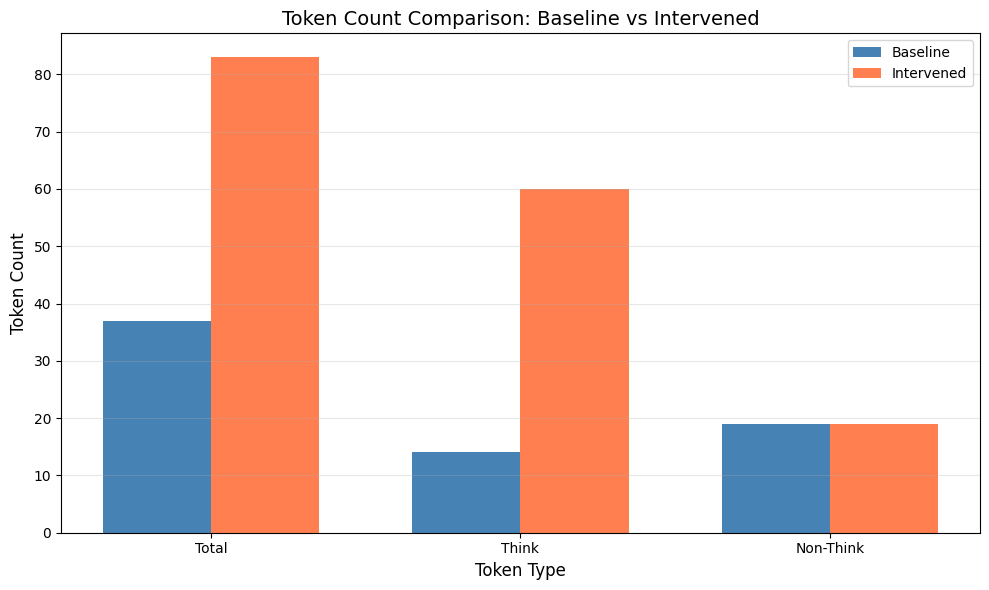

In [8]:
# Token count comparison
categories = ['Total', 'Think', 'Non-Think']
baseline_values = [
    baseline_counts['total_tokens'],
    baseline_counts['think_tokens'],
    baseline_counts['non_think_tokens']
]
intervened_values = [
    intervened_counts['total_tokens'],
    intervened_counts['think_tokens'],
    intervened_counts['non_think_tokens']
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='steelblue')
bars2 = ax.bar(x + width/2, intervened_values, width, label='Intervened', color='coral')

ax.set_xlabel('Token Type', fontsize=12)
ax.set_ylabel('Token Count', fontsize=12)
ax.set_title('Token Count Comparison: Baseline vs Intervened', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

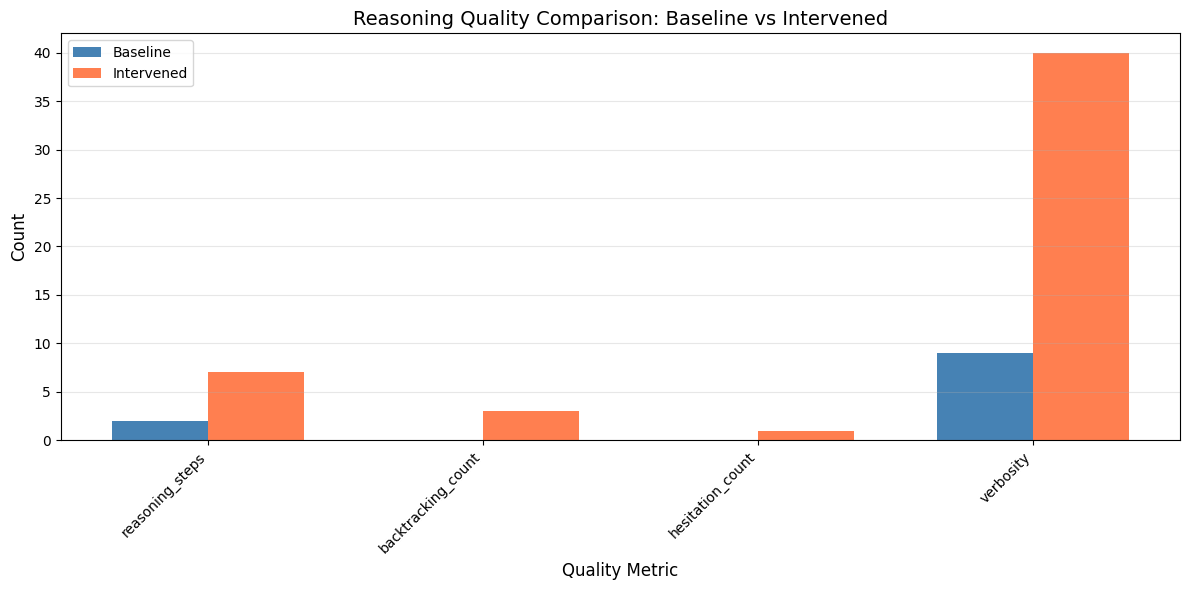

In [9]:
# Reasoning quality comparison
quality_metrics = ['reasoning_steps', 'backtracking_count', 'hesitation_count', 'verbosity']
baseline_quality_values = [baseline_quality[m] for m in quality_metrics]
intervened_quality_values = [intervened_quality[m] for m in quality_metrics]

x = np.arange(len(quality_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, baseline_quality_values, width, label='Baseline', color='steelblue')
bars2 = ax.bar(x + width/2, intervened_quality_values, width, label='Intervened', color='coral')

ax.set_xlabel('Quality Metric', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Reasoning Quality Comparison: Baseline vs Intervened', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(quality_metrics, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Load and Analyze Intervention Results

In [10]:
# Load results from intervention experiments
try:
    with open('/scratch/gilbreth/sramishe/results_QwQ_R1/results/results.json', 'r') as f:
        results_data = json.load(f)
    
    intervention_results = results_data.get('intervention_results', [])
    print(f"Loaded {len(intervention_results)} intervention results")
except:
    print("No results file found. Run intervention.ipynb first.")
    intervention_results = []

No results file found. Run intervention.ipynb first.


## Analyze Layer Sensitivity

In [11]:
if intervention_results:
    sensitivity = evaluator.analyze_layer_sensitivity(intervention_results, metric='token_count')
    
    print("Layer Sensitivity Analysis:")
    for layer, stats in sorted(sensitivity.items())[:5]:  # Show first 5 layers
        print(f"\nLayer {layer}:")
        for key, value in stats.items():
            print(f"  {key}: {value:.2f}")

In [12]:
# Visualize layer sensitivity
if intervention_results:
    layers = sorted(sensitivity.keys())
    ranges = [sensitivity[layer]['range'] for layer in layers]
    means = [sensitivity[layer]['mean'] for layer in layers]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.bar(layers, ranges, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Layer Index', fontsize=12)
    ax1.set_ylabel('Token Count Range', fontsize=12)
    ax1.set_title('Layer Sensitivity (Range)', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2.plot(layers, means, marker='o', linewidth=2, markersize=8, color='coral')
    ax2.set_xlabel('Layer Index', fontsize=12)
    ax2.set_ylabel('Mean Token Count', fontsize=12)
    ax2.set_title('Average Token Count by Layer', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Identify Critical Layers

In [13]:
if intervention_results:
    critical_layers = evaluator.identify_critical_layers(sensitivity, threshold_percentile=75)
    
    print(f"Critical layers (top 25% by sensitivity): {critical_layers}")

## Generate Evaluation Report

In [14]:
if intervention_results:
    report = evaluator.generate_report(
        intervention_results,
        output_file='../results/evaluation_report.txt'
    )
    
    print(report)